# Kyrie Learning
## Introduction
The goal of this project is to use Reinforcement Learning to find low risk layup techniques that players should favorite as develop they're accuracy and precision.

The plan is to model a basketball hoop and a basketball with position, trajectory and english as an MDP and use tansition probabilities to model the lack of accuracy and precision.

Challenges include:
- Modeling the intricate physics involved with a ball spinningof a backboard. The physics model must account for the coefficient of friction, the duration of contact, mechanics of impulse, and other phenomena between the ball and board. The correctness of this project relies heavily on the correctness of the physics.
- Visualizing the data. This will also make it hard to debug but maybe I andhave a 3D plot that justs the trajectory and maybe separately a generatedanimate of a ball spinning to describe the english

In [68]:
### CONSTANT
BACKBOARD_HEIGHT = 3
RIM_HEIGHT = 0.5 + BACKBOARD_HEIGHT

## Model
First we make a 3D plot to display the trajectory of our ball as it makes contact with the backboard.

### Physics Module

In [81]:
import numpy as np

def projectile_motion(initial_position, initial_velocity, gravity=-32.17, time_step=0.025, y_limit=6 - (((9.43 + 9.51)/ 2 / 12) / 2)):
    """
    Simulates projectile motion in 3D space.

    :param initial_position: A list or tuple with the initial position [x, y, z].
    :param initial_velocity: A list or tuple with the initial velocity [vx, vy, vz].
    :param gravity: The gravitational acceleration (negative value).
    :param time_step: The time interval for each step in seconds.
    :param y_limit: The y-value at which the simulation stops.
    :return: List of position vectors representing the projectile's trajectory.
    """
    position = np.array(initial_position)
    velocity = np.array(initial_velocity)
    positions = [position.copy()]

    count = 0
    while position[1] < y_limit and 100 > count:
        velocity[2] += gravity * time_step  # Update the y-component of the velocity
        
        position += velocity * time_step  # Update position
        positions.append(position.copy())
        count += 1
        print(velocity, position)
    
    velocity[1] *= -1
    while position[2] > RIM_HEIGHT and 100 > count:
        velocity[2] += gravity * time_step  # Update the y-component of the velocity
        
        position += velocity * time_step  # Update position
        positions.append(position.copy())
        count += 1
        print(velocity, position)
        
    
    return positions

# set initial values
initial_pos = [4, 4, 1.5]  
initial_vel = [1., 1.5, 20.]

trajectory = projectile_motion(initial_pos, initial_vel)


[ 1.       1.5     19.19575] [4.025      4.0375     1.97989375]
[ 1.      1.5    18.3915] [4.05       4.075      2.43968125]
[ 1.       1.5     17.58725] [4.075     4.1125    2.8793625]
[ 1.     1.5   16.783] [4.1       4.15      3.2989375]
[ 1.       1.5     15.97875] [4.125      4.1875     3.69840625]
[ 1.      1.5    15.1745] [4.15       4.225      4.07776875]
[ 1.       1.5     14.37025] [4.175    4.2625   4.437025]
[ 1.     1.5   13.566] [4.2      4.3      4.776175]
[ 1.       1.5     12.76175] [4.225      4.3375     5.09521875]
[ 1.      1.5    11.9575] [4.25       4.375      5.39415625]
[ 1.       1.5     11.15325] [4.275     4.4125    5.6729875]
[ 1.     1.5   10.349] [4.3       4.45      5.9317125]
[1.      1.5     9.54475] [4.325      4.4875     6.17033125]
[1.     1.5    8.7405] [4.35       4.525      6.38884375]
[1.      1.5     7.93625] [4.375   4.5625  6.58725]
[1.    1.5   7.132] [4.4     4.6     6.76555]
[1.      1.5     6.32775] [4.425      4.6375     6.92374375]
[1.  

### Basketball Plot

In [82]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def set_axes_equal(ax):
    """Set 3D plot axes to equal scale."""
    extents = np.array([getattr(ax, f'get_{dim}lim')() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize / 2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, f'set_{dim}lim')(ctr - r, ctr + r)

def add_ball_to_plot(ax, center, diameter_in_inches):
    # Convert diameter from inches to feet (1 inch = 1/12 feet)
    radius = (diameter_in_inches / 2) / 12  # Radius in feet

    # Create a meshgrid for the sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]  # Increased mesh resolution
    x = center[0] + radius * np.cos(u) * np.sin(v)
    y = center[1] + radius * np.sin(u) * np.sin(v)
    z = center[2] + radius * np.cos(v)

    # Plot the sphere
    ax.plot_surface(x, y, z, color='brown', alpha=0.6)

    # Set equal aspect ratio for the axes
    set_axes_equal(ax)

### Main function

In [83]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import numpy as np
from functools import lru_cache

@lru_cache(maxsize=None)
def load_and_process_image(image_path):
    # Load the image using matplotlib.image
    img = mpimg.imread(image_path)

    # Check if the image has an alpha channel (RGBA), if so, remove the alpha channel
    if img.shape[2] == 4:
        img = img[:, :, :3]

    # Flip the image vertically
    return np.flipud(img)

def plot_hoop(ax, center_x, center_y, hoop_height, major_diameter, minor_diameter, color='orange'):
    # Define the parametric equations for a torus (hoop)
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, 2 * np.pi, 100)
    u, v = np.meshgrid(u, v)

    # Parameters for the torus
    r = minor_diameter / 2
    R = major_diameter / 2

    # Equations for the torus
    x = (R + r * np.cos(v)) * np.cos(u)
    y = (R + r * np.cos(v)) * np.sin(u)
    z = r * np.sin(v)

    # Positioning the hoop
    x += center_x
    y += center_y - (major_diameter / 2)  # Adjust to position the hoop vertically
    z += hoop_height

    # Plot the hoop
    ax.plot_surface(x, y, z, color=color, rstride=5, cstride=5, shade=True)

def plot_points(ax, points, point_color='blue', point_marker='o', point_size=5):
    """
    Plots a list of points on the given 3D axes.
    :param ax: The 3D axes to plot the points on.
    :param points: A list of tuples/lists representing the points (x, y, z).
    :param point_color: Color of the points.
    :param point_marker: Marker style for the points.
    :param point_size: Size of the points.
    """
    for point in points:
        ax.scatter(*point, c=point_color, marker=point_marker, s=point_size)

def plot_model(img, view_angle=(30, 60), width=6, height=3.5, center_x=6, center_y=6, hoop_height=3):
    # Create a 3D plot
    fig = plt.figure(figsize=(24, 18))
    ax = fig.add_subplot(111, box_aspect=(1,1,1), projection='3d')

    # Calculate the position of the image
    half_width = width / 2
    half_height = height / 2
    x = np.linspace(center_x - half_width, center_x + half_width, img.shape[1])
    z = np.linspace(hoop_height, hoop_height + height, img.shape[0])
    x, z = np.meshgrid(x, z)
    y = np.full(x.shape, center_y)

    # Plot the image
    ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=img, shade=False)

    # Setting the limits of the plot based on the rectangle size and position
    ax.set_xlim([0, center_x * 2])
    ax.set_ylim([0, center_y])
    ax.set_zlim([0, 10])
    ax.set_proj_type('persp')

    # Set the viewing angle
    ax.view_init(elev=view_angle[0], azim=view_angle[1])

    # Labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('Custom 3D Plot with Image')
    
    HOOP_DIAMETER = 1.5
    HOOP_THICKNESS = 0.05208
    plot_hoop(ax, center_x, center_y- (HOOP_DIAMETER / 2) + 0.5, 0.5 + hoop_height, HOOP_DIAMETER - (HOOP_THICKNESS / 2), HOOP_THICKNESS)
    
    # Example points to plot
    points_to_plot = trajectory
    add_ball_to_plot(ax, points_to_plot[-1], (9.43 + 9.51)/ 2)
    # Plot points
    plot_points(ax, points_to_plot)
    
    

    plt.show()

    return ax

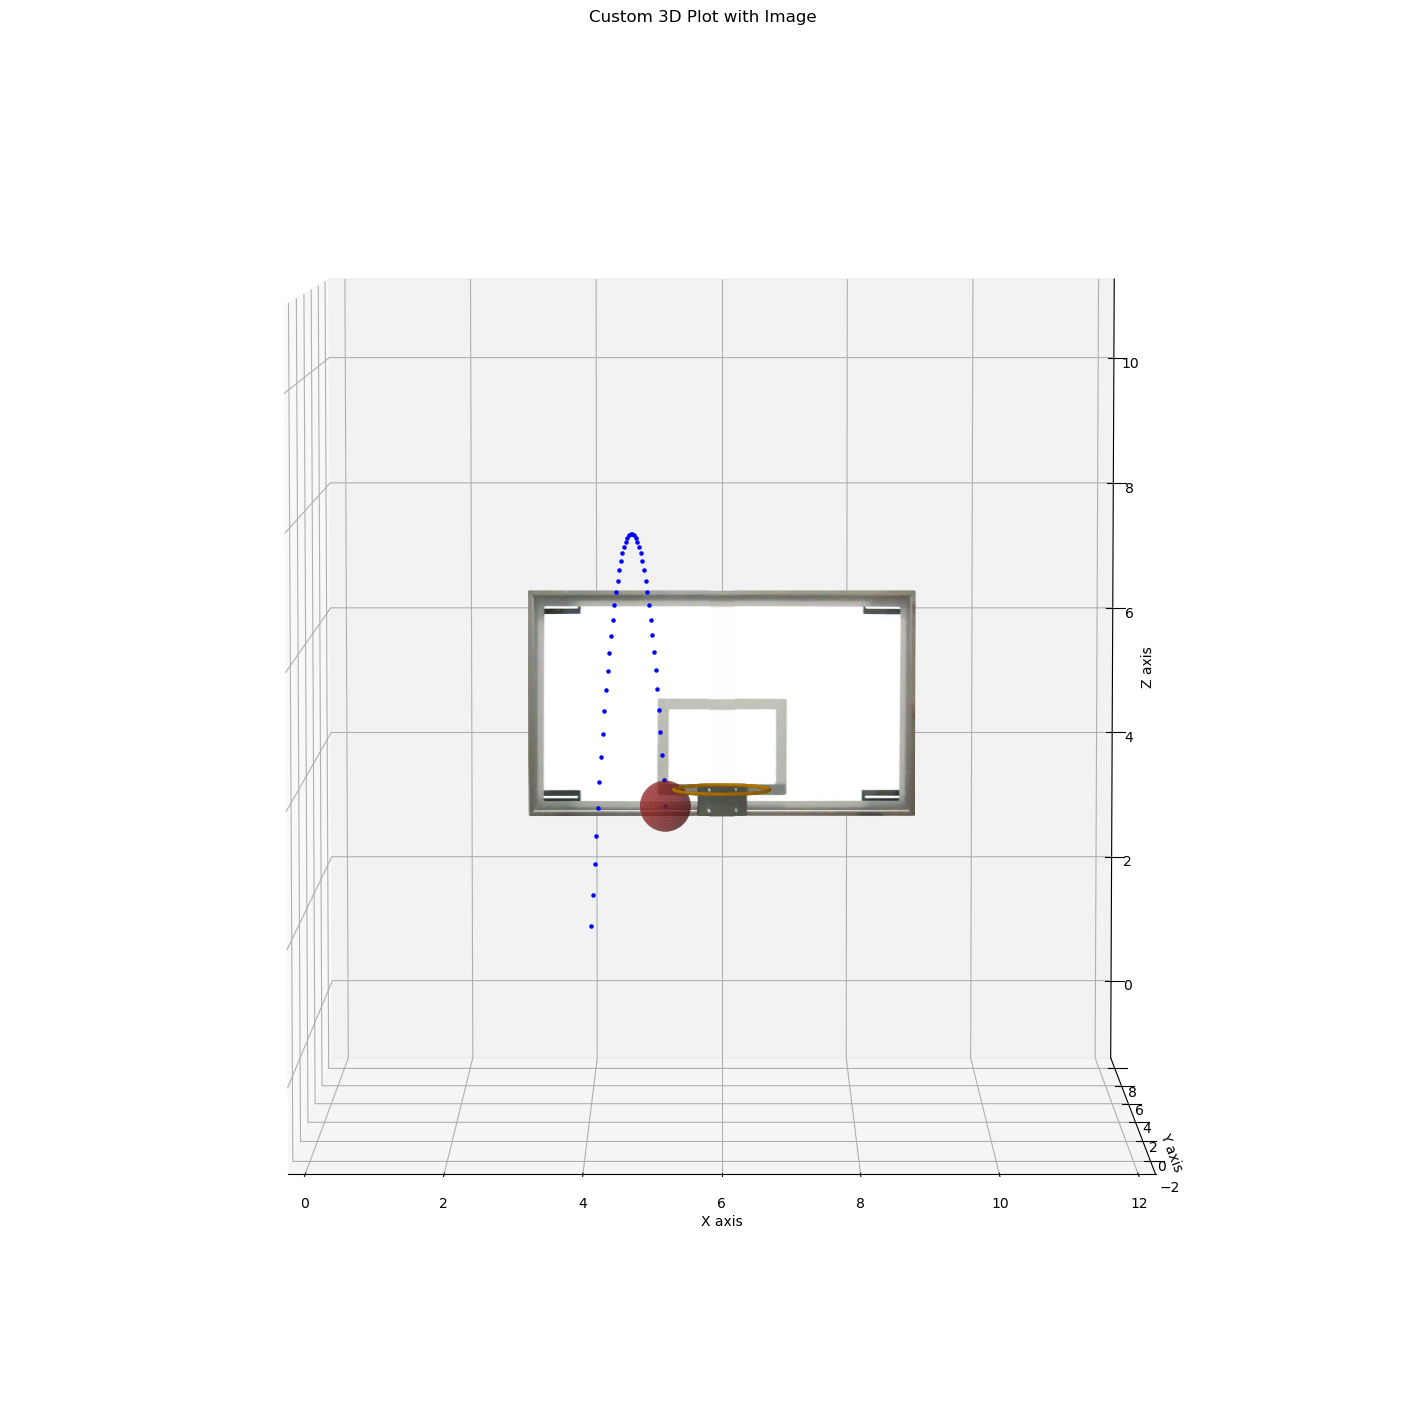

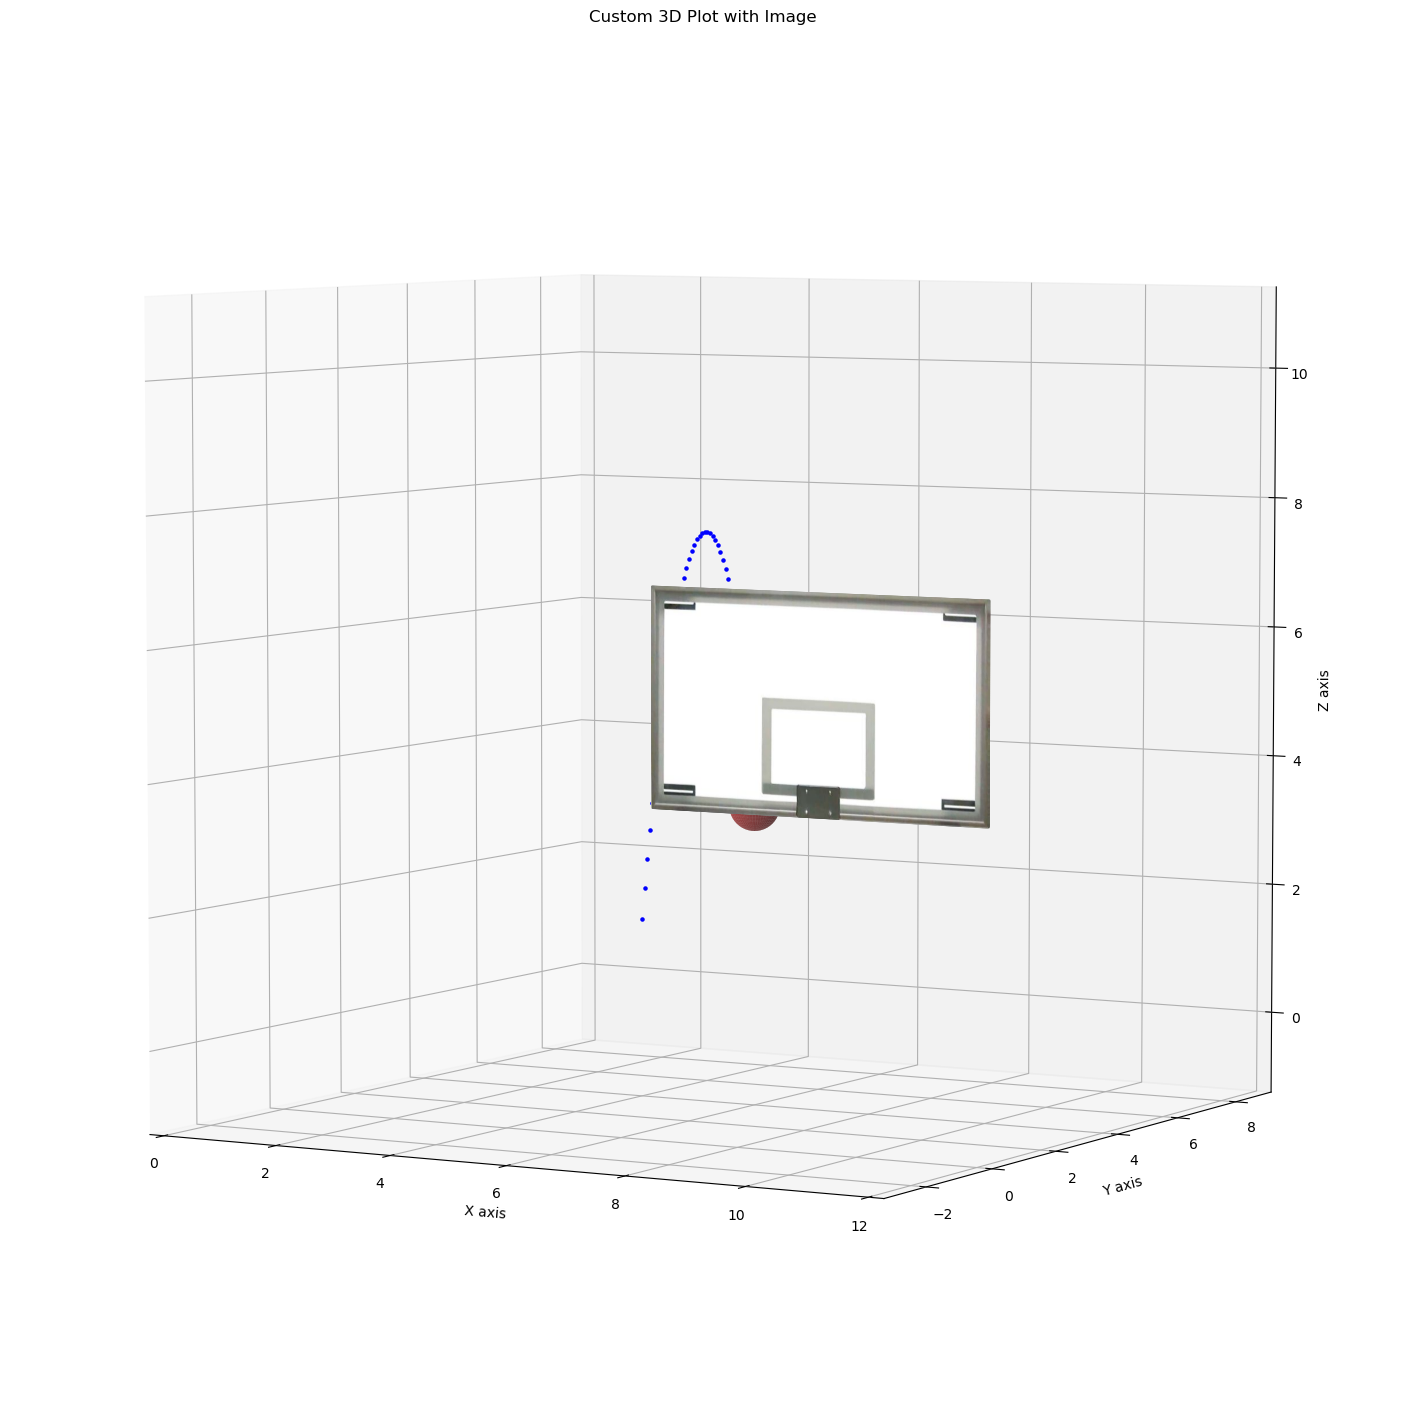

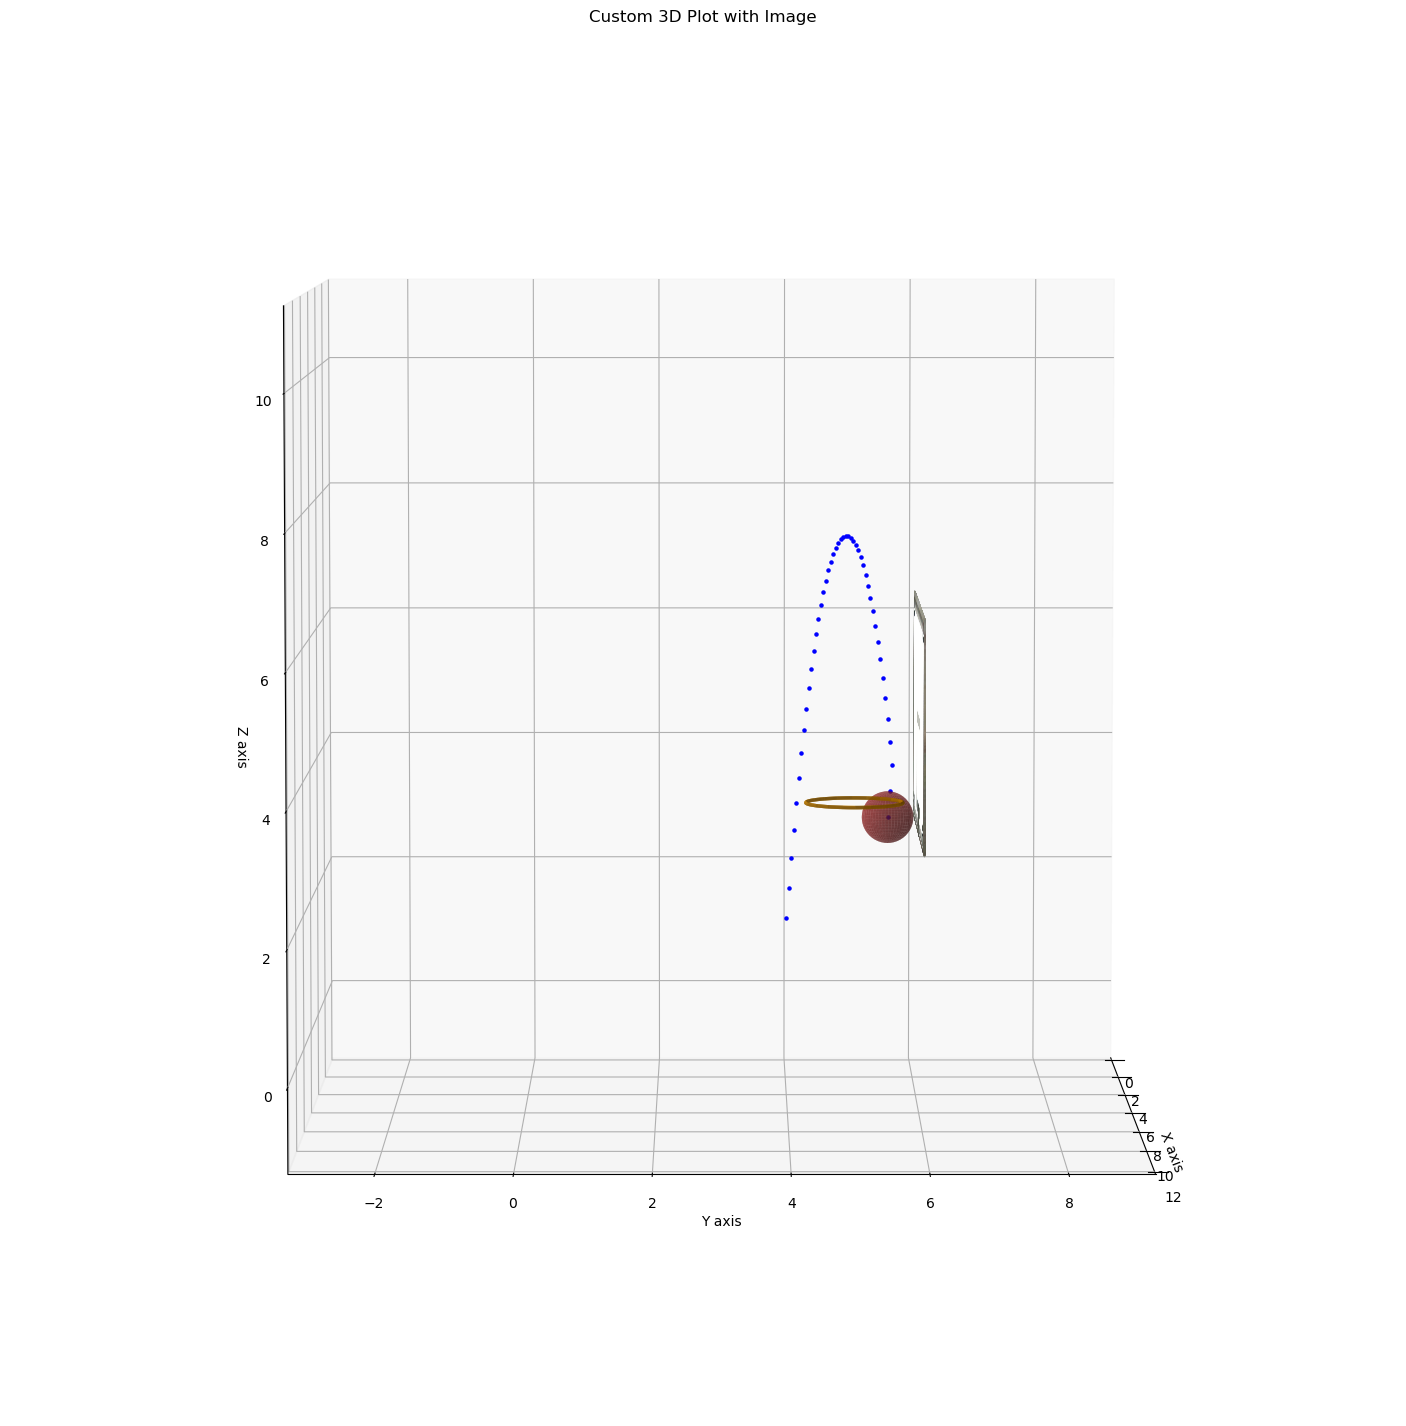

Wall time: 43.2 s


<Axes3DSubplot:title={'center':'Custom 3D Plot with Image'}, xlabel='X axis', ylabel='Y axis'>

In [85]:
%%time
# Example usage
image_path = "./backboard.png"
img = load_and_process_image(image_path)
plot_model(img, view_angle=(5, -90))
plot_model(img, view_angle=(5, -60))
plot_model(img, view_angle=(5, 0))